# This file shows how I learned about and created the image classification model.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

import glob
plt.rcParams['figure.figsize'] = (10,12)

2023-03-13 09:38:05.676835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* These import statements were collected from various teaching materials, I am unsure of the best practices when importing tensorflow or keras libraries.

In [2]:
from tensorflow import keras
from keras import preprocessing
from tensorflow.keras.preprocessing import image
import keras.backend as K
from keras.applications.mobilenet import MobileNet, decode_predictions, preprocess_input
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,InputLayer,Dropout

### This model is based upon the MobileNet() Project found here:

* https://keras.io/api/applications/mobilenet/

In [3]:
model = MobileNet()

2023-03-13 09:38:09.978838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* In order to train my model, I used over 1_000 images of waterbottles and empty rooms.
* In order to save on space, I did not upload these images.

In [4]:
base_path = "../train_data/"
classes = ['chris_bottle','crista_bottle','gerrit_bottle',
           'helge_bottle','himansu_bottle','moritz_bottle',
           'mykola_bottle','nazila_bottle','renato_bottle',
           'simantini_bottle','empty']

* Here I define what types of preprocessing to take. I tried out a few and marked what each one does.

In [5]:
data_gen = preprocessing.image.ImageDataGenerator(   # loads data in batches from disk
    preprocessing_function=preprocess_input,
    # fill_mode='nearest',                           # fill points outside boundry with the nearest pixel
    rotation_range=20,                               # rotate image by a random degree between -20 and 20
    # width_shift_range=0.2,                         # shift image horizontally 
    # height_shift_range=0.2,                        # shift image vertically 
    # horizontal_flip=True,                          # randomly flip image horizontally
    zoom_range=0.5,                                  # apply zoom transformation using zoom factor between 0.5 and 1.5
    # shear_range=0.2                                # shear rotates pics, but makes them be in trapezoids (as opposed to squares)
    validation_split=0.2                             # split given data into validation and testing
)

* Here I use the data_gen method to define my data and its subset.

In [6]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=150,
        target_size=(224, 224),
    subset='training'
)

Found 1316 images belonging to 11 classes.


In [7]:
val_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=150,
        target_size=(224, 224),
    subset='validation'
)

Found 324 images belonging to 11 classes.


* Here we can see the classes and their indicies that will be used in sorting categories when the model builds.

In [8]:
train_data_gen.class_indices

{'chris_bottle': 0,
 'crista_bottle': 1,
 'gerrit_bottle': 2,
 'helge_bottle': 3,
 'himansu_bottle': 4,
 'moritz_bottle': 5,
 'mykola_bottle': 6,
 'nazila_bottle': 7,
 'renato_bottle': 8,
 'simantini_bottle': 9,
 'empty': 10}

In [9]:
classes

['chris_bottle',
 'crista_bottle',
 'gerrit_bottle',
 'helge_bottle',
 'himansu_bottle',
 'moritz_bottle',
 'mykola_bottle',
 'nazila_bottle',
 'renato_bottle',
 'simantini_bottle',
 'empty']

* Be sure to include a clear_session statement to avoid any befuddling models.

In [10]:
K.clear_session()
base_model = MobileNet(
    weights='imagenet',
    include_top=False, # <-- Here we specify not to include the last few layers, I will define my own methods and category numbers
    input_shape=(224, 224, 3)
)

* Be sure to specify that the pretrained model should not be affected by this new training.

In [11]:
base_model.trainable = False 

### Here I modify the model to include my output layers.

* I used one dense layer using ReLu as the activation function.
* I dropped 30% of nodes during back propogation to avoid overfitting.
* Finally I specified how many categories to include and activate using softmax

In [12]:
model = keras.Sequential()
model.add(base_model)
model.add(Flatten())  
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))

### We define an optimization process so that our model can learn efficiently.

* I used Adam optimization with a 0.001 learning rate, both industry standards
* Categorical cross entropy is the typcial loss function for categorical training.

In [13]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

### Here I decided to use early stopping

* I stopped the model if it improves by less than 0.05 in a span of 3 iterations.

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.05,     # the minimum expected change in the metric used in order to be seen as an improvement
    patience=3,         # number of epochs with no improvement needed for the model to stop
    restore_best_weights=True,
    mode='min'
    )

### Fit the model to the data using all of our predefined variables

In [14]:
history = model.fit(train_data_gen,
          verbose=2, 
          callbacks=[callback],
          epochs=20,
          validation_data=val_data_gen
          )

Epoch 1/20
9/9 - 50s - loss: 7.0742 - categorical_accuracy: 0.4415 - val_loss: 0.5361 - val_categorical_accuracy: 0.7870 - 50s/epoch - 6s/step
Epoch 2/20
9/9 - 40s - loss: 0.5118 - categorical_accuracy: 0.8313 - val_loss: 0.1913 - val_categorical_accuracy: 0.9383 - 40s/epoch - 4s/step
Epoch 3/20
9/9 - 42s - loss: 0.2721 - categorical_accuracy: 0.9005 - val_loss: 0.1345 - val_categorical_accuracy: 0.9691 - 42s/epoch - 5s/step
Epoch 4/20
9/9 - 46s - loss: 0.1854 - categorical_accuracy: 0.9384 - val_loss: 0.0860 - val_categorical_accuracy: 0.9846 - 46s/epoch - 5s/step
Epoch 5/20
9/9 - 40s - loss: 0.1164 - categorical_accuracy: 0.9605 - val_loss: 0.0473 - val_categorical_accuracy: 0.9846 - 40s/epoch - 4s/step
Epoch 6/20
9/9 - 40s - loss: 0.1050 - categorical_accuracy: 0.9574 - val_loss: 0.0550 - val_categorical_accuracy: 0.9753 - 40s/epoch - 4s/step
Epoch 7/20
9/9 - 40s - loss: 0.0867 - categorical_accuracy: 0.9696 - val_loss: 0.0224 - val_categorical_accuracy: 0.9938 - 40s/epoch - 4s/step

### Let's plot how the model progressed.

In [21]:
logs = pd.DataFrame(history.history)

<Axes: >

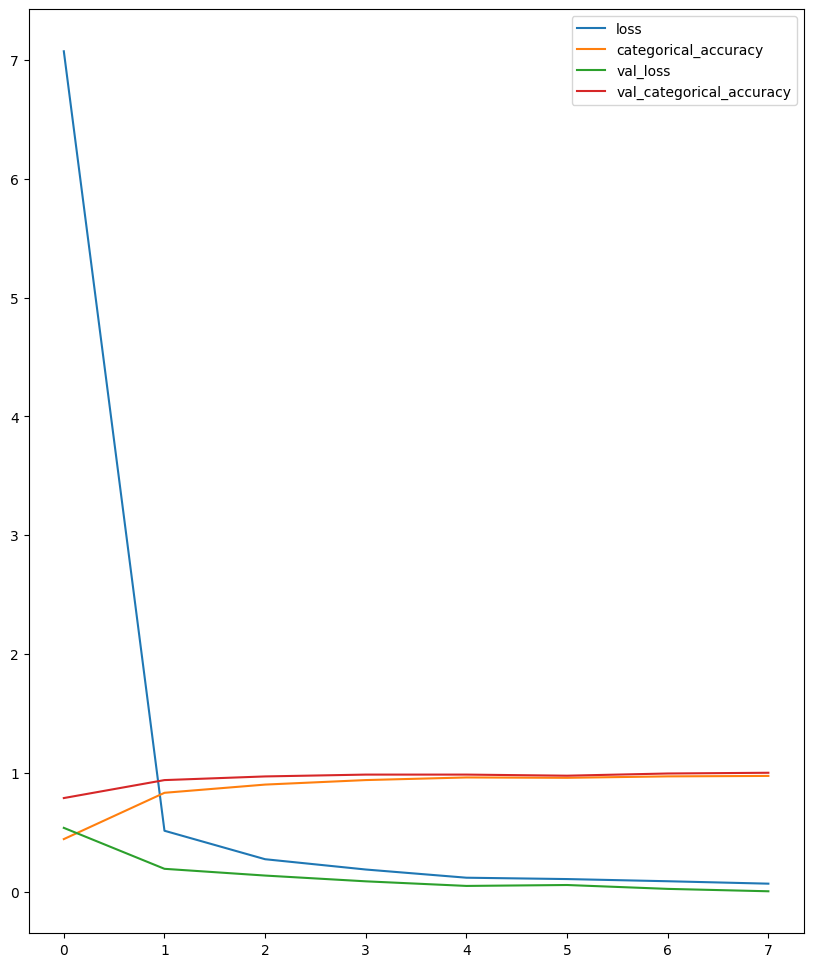

In [22]:
logs.plot()

### Now we test our model on a new set of images.

In [23]:
test_path = '../test_data/*/*'

In [24]:
def batch_prediction(path=test_path):
    for i,img_path in enumerate(glob.glob(test_path)):

        img = image.load_img(img_path,target_size=(224,224))
        actual_label = img_path[13:-25]

        x = np.array(img)
        X = np.array([x]) 
        X_preprocess = preprocess_input(X)

        pred = model.predict(X_preprocess)

        plt.subplot(7,2, i+1);
        plt.tight_layout()
        plt.imshow(img)
        plt.title(f"""actual label is {actual_label} \n predicted as {classes[pred.argmax()]}""" )

1/1 [==============================] - 0s 45ms/step


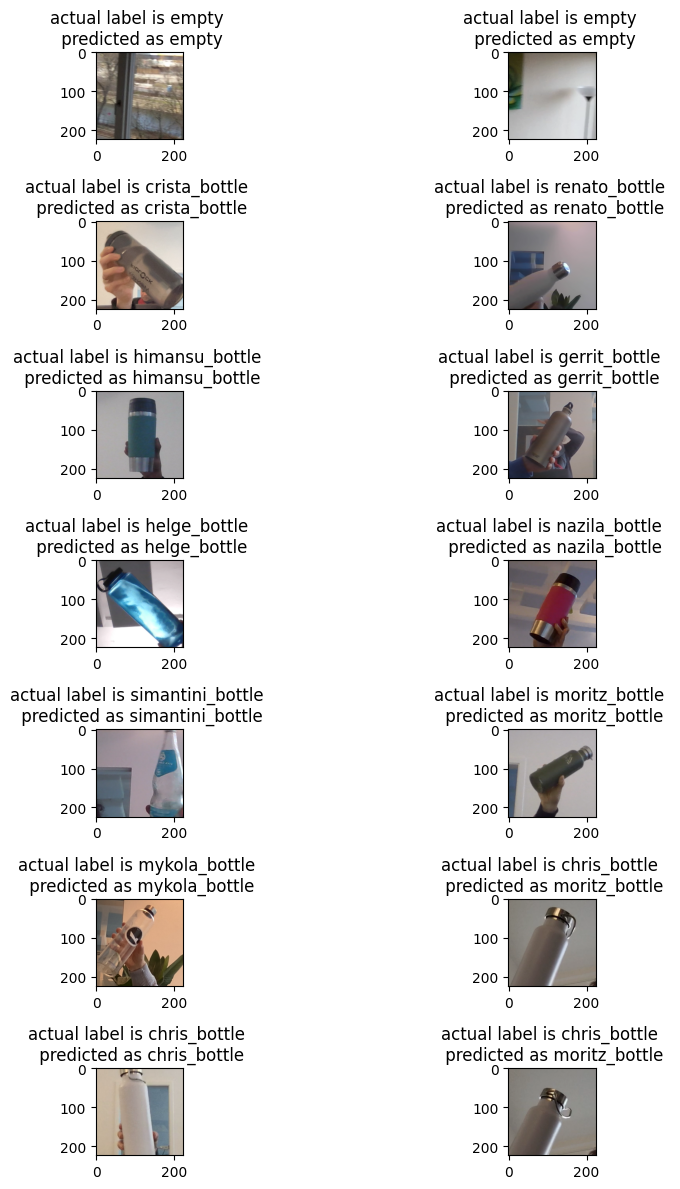

In [25]:
batch_prediction()

### Interesting.

* We can see that not only does the color of the bottle matter, but the amount of lighting does as well.
* When Chris' bottle is in shade, the model has trouble differing the shady white from the dark green.
* Perhaps a different type of preprocessing could be used to account for this.

In [20]:
model.save('water_bottles.h5')